In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy
import statsmodels.api as sm
import os

In [11]:
filenames = ['credit_suisse.csv', 'DB.csv', 'SBNYP.csv', 'SIVB.csv']

# Initialize an empty dictionary to store DataFrames
data_dict = {}

# Read each CSV file into a DataFrame and store it in the dictionary
for filename in filenames:
    # Extract the bank name from the filename (removing '.csv' extension)
    bank_name = filename.split('.')[0]
    df = pd.read_csv(filename)
    data_dict[bank_name] = df

# Display the keys of the dictionary to verify
print(data_dict.keys())

# Optionally, display the first few rows of each DataFrame
for bank_name, df in data_dict.items():
    print(f"Data for {bank_name}:")
    print(df.head())
    print()

dict_keys(['credit_suisse', 'DB', 'SBNYP', 'SIVB'])
Data for credit_suisse:
         Date   Open   High    Low  Close  Adj Close   Volume
0  2017-01-03  15.11  15.30  15.03  15.26  12.826453  7462400
1  2017-01-04  15.80  15.98  15.60  15.96  13.414824  7671900
2  2017-01-05  15.68  15.83  15.44  15.72  13.213097  5451100
3  2017-01-06  15.58  15.76  15.56  15.68  13.179476  4017000
4  2017-01-09  15.52  15.72  15.44  15.61  13.120638  2806300

Data for DB:
         Date       Open       High        Low      Close  Adj Close    Volume
0  2017-01-03  18.440001  18.540001  18.280001  18.430000  17.351194   6169500
1  2017-01-04  19.020000  19.629999  18.940001  19.570000  18.424461  11142800
2  2017-01-05  19.459999  19.570000  19.049999  19.260000  18.132608   6169900
3  2017-01-06  19.150000  19.389999  19.120001  19.270000  18.142025   4631300
4  2017-01-09  18.950001  19.180000  18.830000  19.049999  17.934900   3670500

Data for SBNYP:
         Date       Open       High        Low 

In [12]:
def get_stats(df, name):
    print(f'Here are some basic stats for {name}')

    print(f'Highest Price recorded: {np.round(df.High.max().item(), 2)} on {df.loc[df.High==df.High.max()].Date.item()}')
    print(f'Lowest Price recorded: {np.round(df.Low.min().item(), 2)} on {df.loc[df.Low==df.Low.min()].Date.item()}')
    print(f'Average Return over time: {df.Close.pct_change().mean() *100}%')
    print(f'Total Return: {np.round((df.Close.iloc[-1]-df.Close.iloc[0])/df.Close.iloc[0] *100, 2)}%')
    df_=df.copy()
    df_['move']=df['Close']-df['Open']
    print(f'Maximum +ve movement in a day: {np.round(max(df_.move), 2)} points on {df_.loc[df_.move==max(df_.move)].Date.item()}')
    print(f'Maximum -ve movement in a day: {np.round(min(df_.move), 2)} points on {df_.loc[df_.move==min(df_.move)].Date.item()}')
    print(f'Standard Deviation: {df.Close.pct_change().std() *100}%')

for name, df in data_dict.items():
    get_stats(df, name)
    print()
    print()

Here are some basic stats for credit_suisse
Highest Price recorded: 19.98 on 2018-01-26
Lowest Price recorded: 0.82 on 2023-03-24
Average Return over time: -0.1348352988317578%
Total Return: -94.23%
Maximum +ve movement in a day: 0.67 points on 2018-02-14
Maximum -ve movement in a day: -0.88 points on 2018-02-08
Standard Deviation: 2.8349850306281446%


Here are some basic stats for DB
Highest Price recorded: 20.94 on 2017-01-25
Lowest Price recorded: 4.99 on 2020-03-16
Average Return over time: -0.001137301812515551%
Total Return: -43.62%
Maximum +ve movement in a day: 0.55 points on 2022-10-13
Maximum -ve movement in a day: -0.96 points on 2022-04-11
Standard Deviation: 2.6552920873421404%


Here are some basic stats for SBNYP
Highest Price recorded: 40.86 on 2021-02-10
Lowest Price recorded: 0.02 on 2023-03-31
Average Return over time: -0.18636803696185303%
Total Return: -99.74%
Maximum +ve movement in a day: 1.2 points on 2022-05-25
Maximum -ve movement in a day: -15.17 points on 2

SBYNP took a massive hit with a -99.75% return, next in queue is SVB.

SVB experienced a 70% drop in its price in 1 trading day!!

All of them have significantly high SD compared to Mean with 3.4 stocks giving negative annual returns. Risky Business.

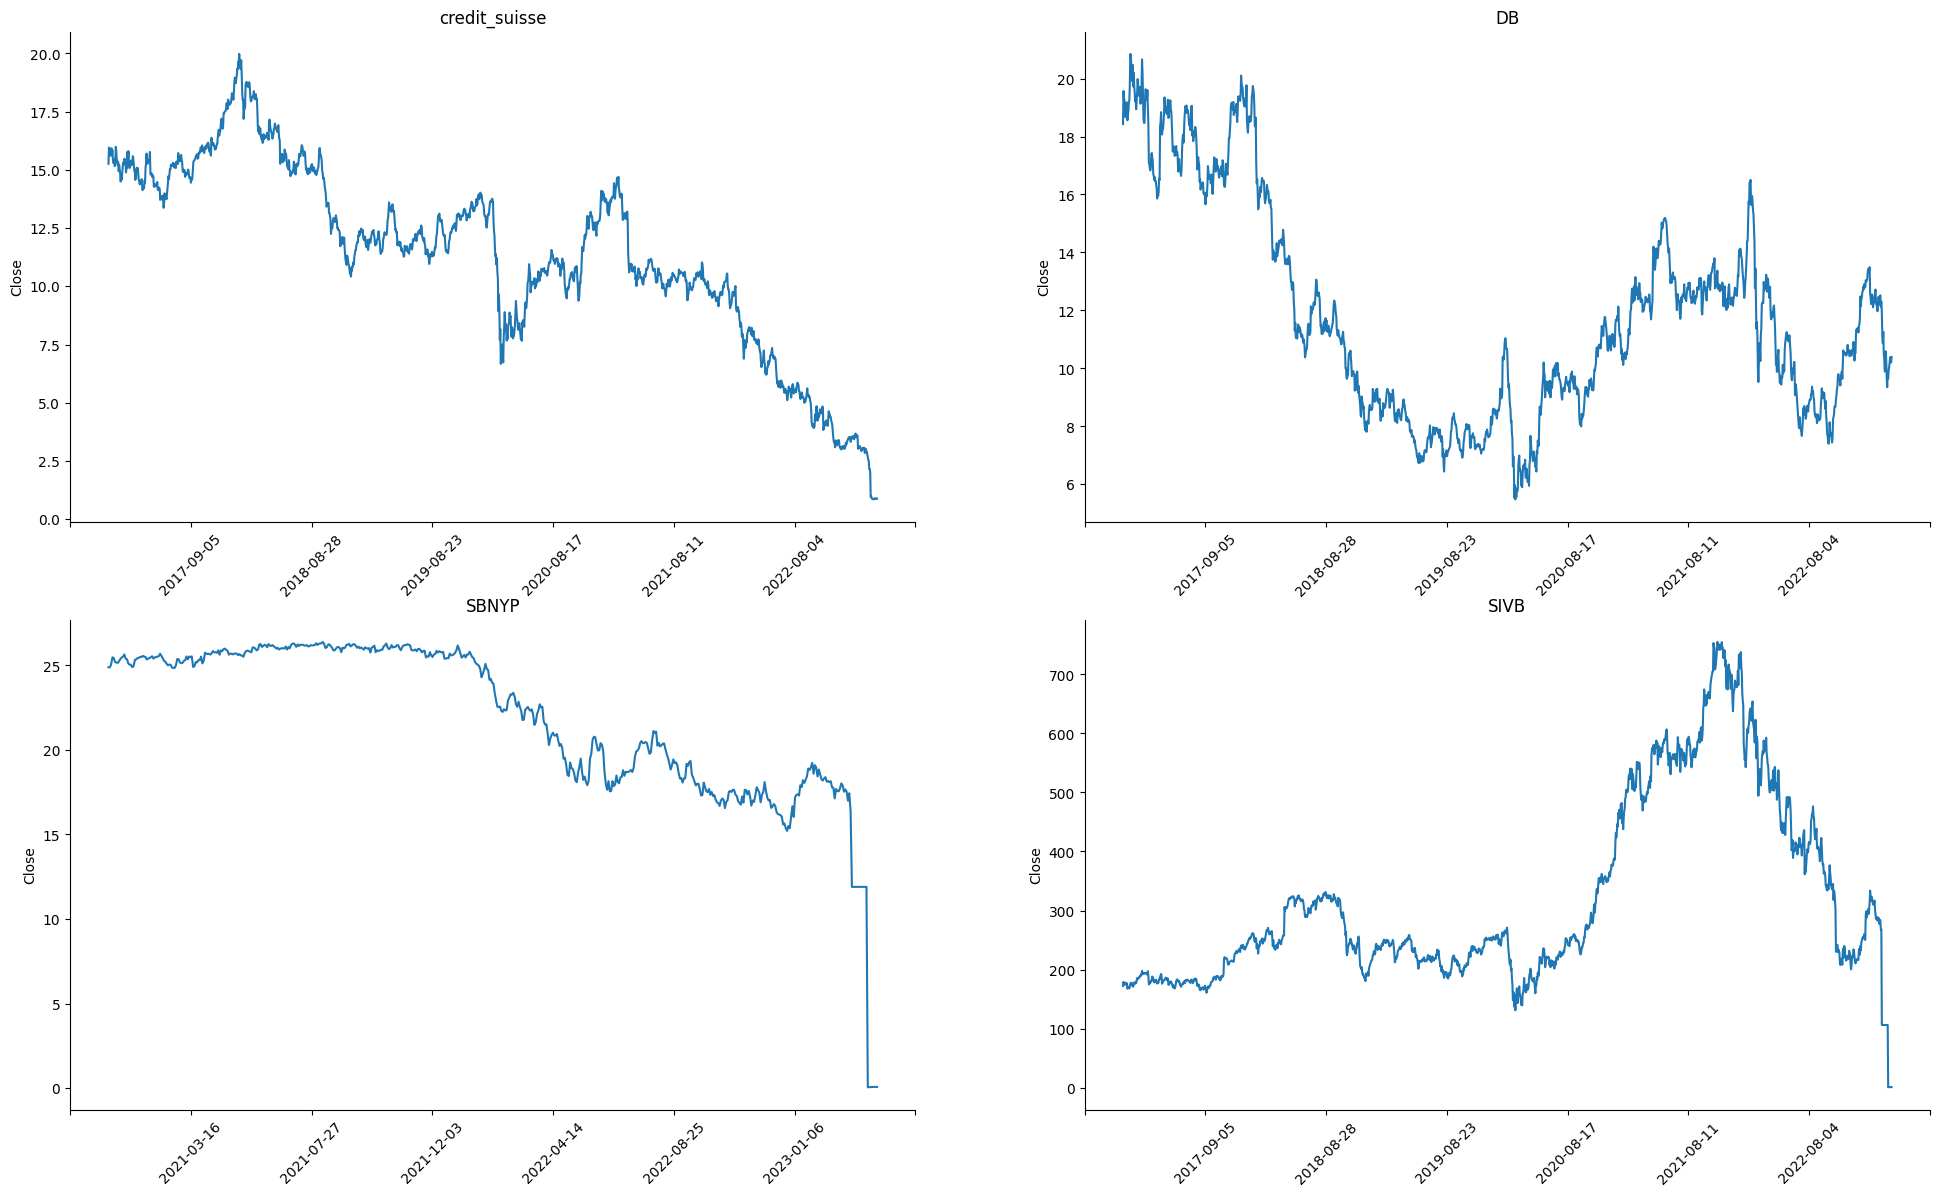

In [13]:
plt.figure(figsize=(24,14))
for i, (name, df) in enumerate(data_dict.items()):
    plt.subplot(2,2,i+1)
    sns.lineplot(data=df, x='Date', y='Close')
    sns.despine()
    xmin, xmax = plt.gca().get_xlim()
    plt.gca().set_xticks(np.round(np.linspace(xmin, xmax, 8), 2))
    plt.gca().set(xlabel=None)
    plt.xticks(rotation=45)
    plt.title(f'{name}')

Signature Bank is was relatively flat till 2022, after which there has been declines.

CS has been going downhill since 2017

SVB rose quite high in 2021 because 2021-2022 the bank had seen surplus deposits and 2021 was the most profitable year for the bank. These surplus deposits were the reason the bank invested in Treasure Bonds and the rest is history

#Return Analysis
Return statistics is where we dive a bit into the returns and try to model it and assign it to a population distribution.

We get the returns using the pct_change function of pandas which subtracts previous value from the current value and divides by previous value. Now it's easy to misinterpret but the values are not percentages themselves. To get the percent, simply multiply by 100.

We first plot a simple histogram of our returns to have a visual of our returns and expectations are a Gaussian-esque distribution.
We then use the Q-Q plot to compare the quantiles of our return samples to the Gaussian distribution or the standard normal. I find this interesting as we can then map out various things like VaR and get a lot more insight into the returns if we can group it into one of the distributions

In [14]:
def return_stats(df, name):
    print(f'Return Stats for {name}')
    df_=df.copy()
    df_['ret']=df_.Close.pct_change()

#     fig=px.histogram(df_, x="ret")
#     fig.update_layout(height=600, width=800)
#     fig.show()
    plt.figure(figsize=(24,10))
    sns.histplot(data=df_, x='ret')
    sm.graphics.qqplot(df_['ret'], line='q')


Return Stats for CS


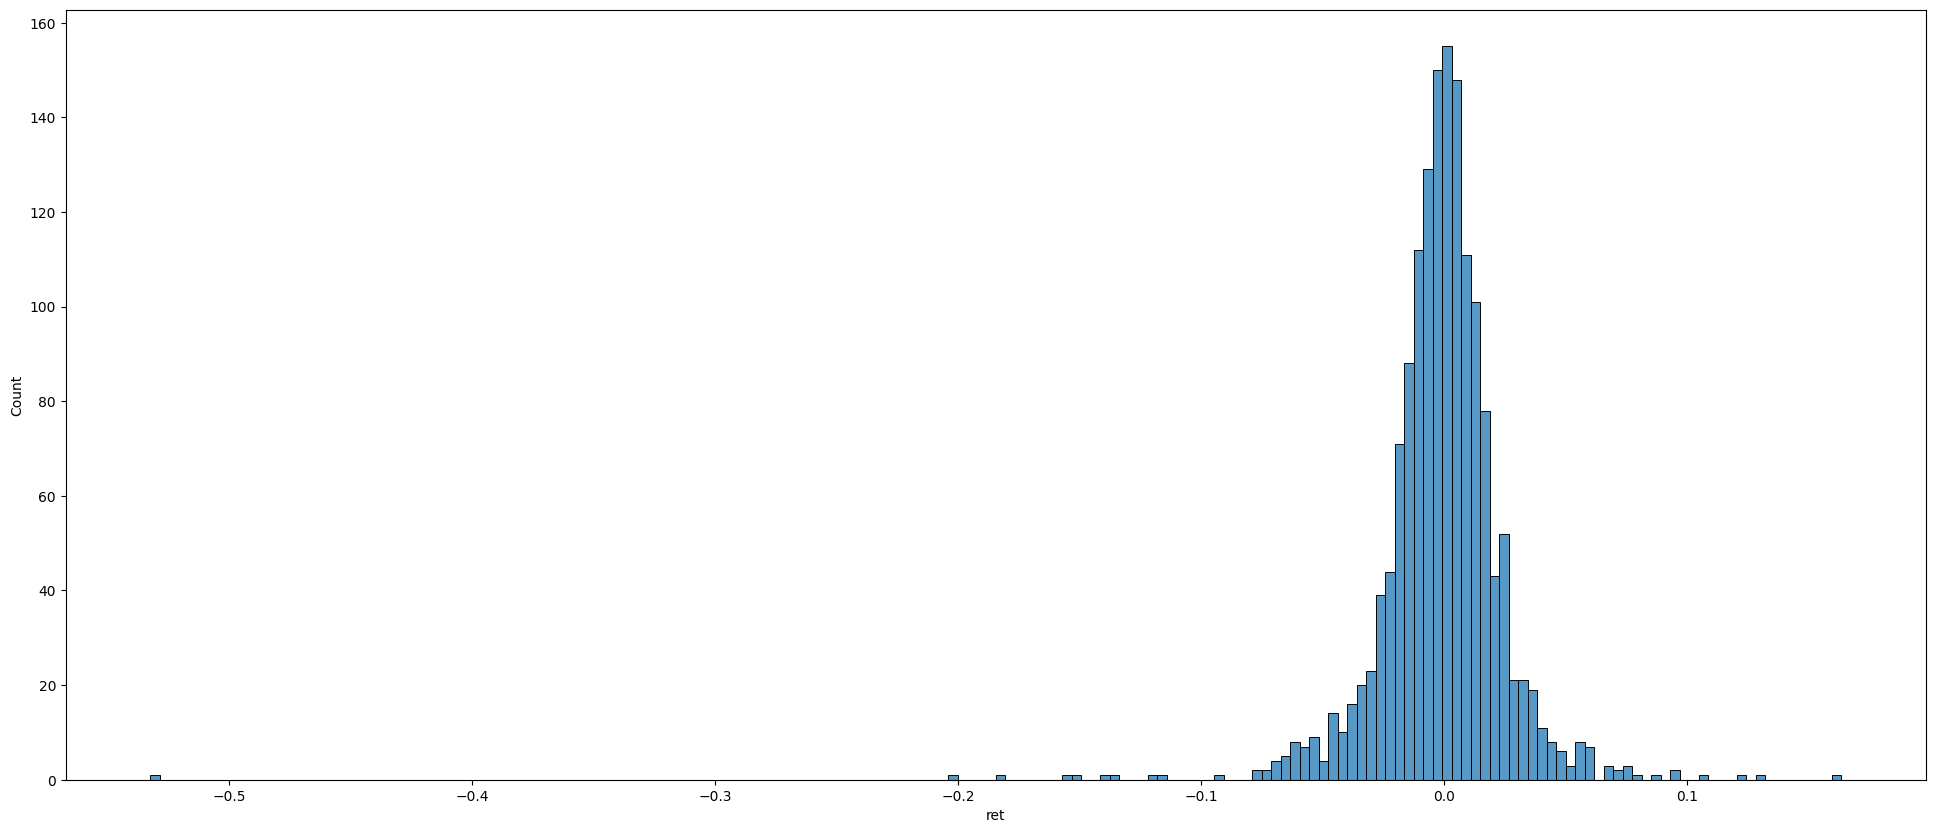

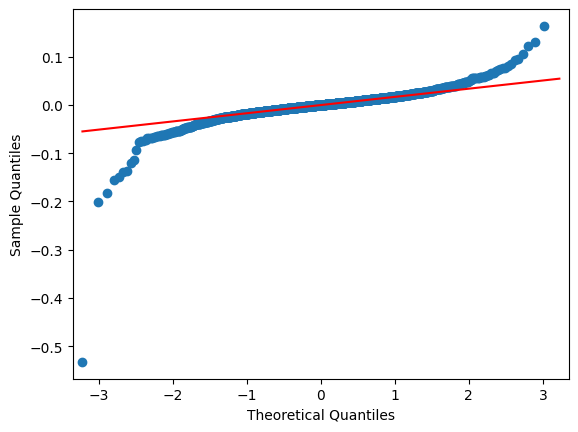

In [16]:
return_stats(data_dict['credit_suisse'], 'CS')

For Credit Suisse,
There are a lot of negative returns. It has thicker tails at the left side than Gaussian especially on the negative end. We can see one huge outlier at the bottom right as well. The data is too peaked and narrow at the center causing thick tails.

Return Stats for DB


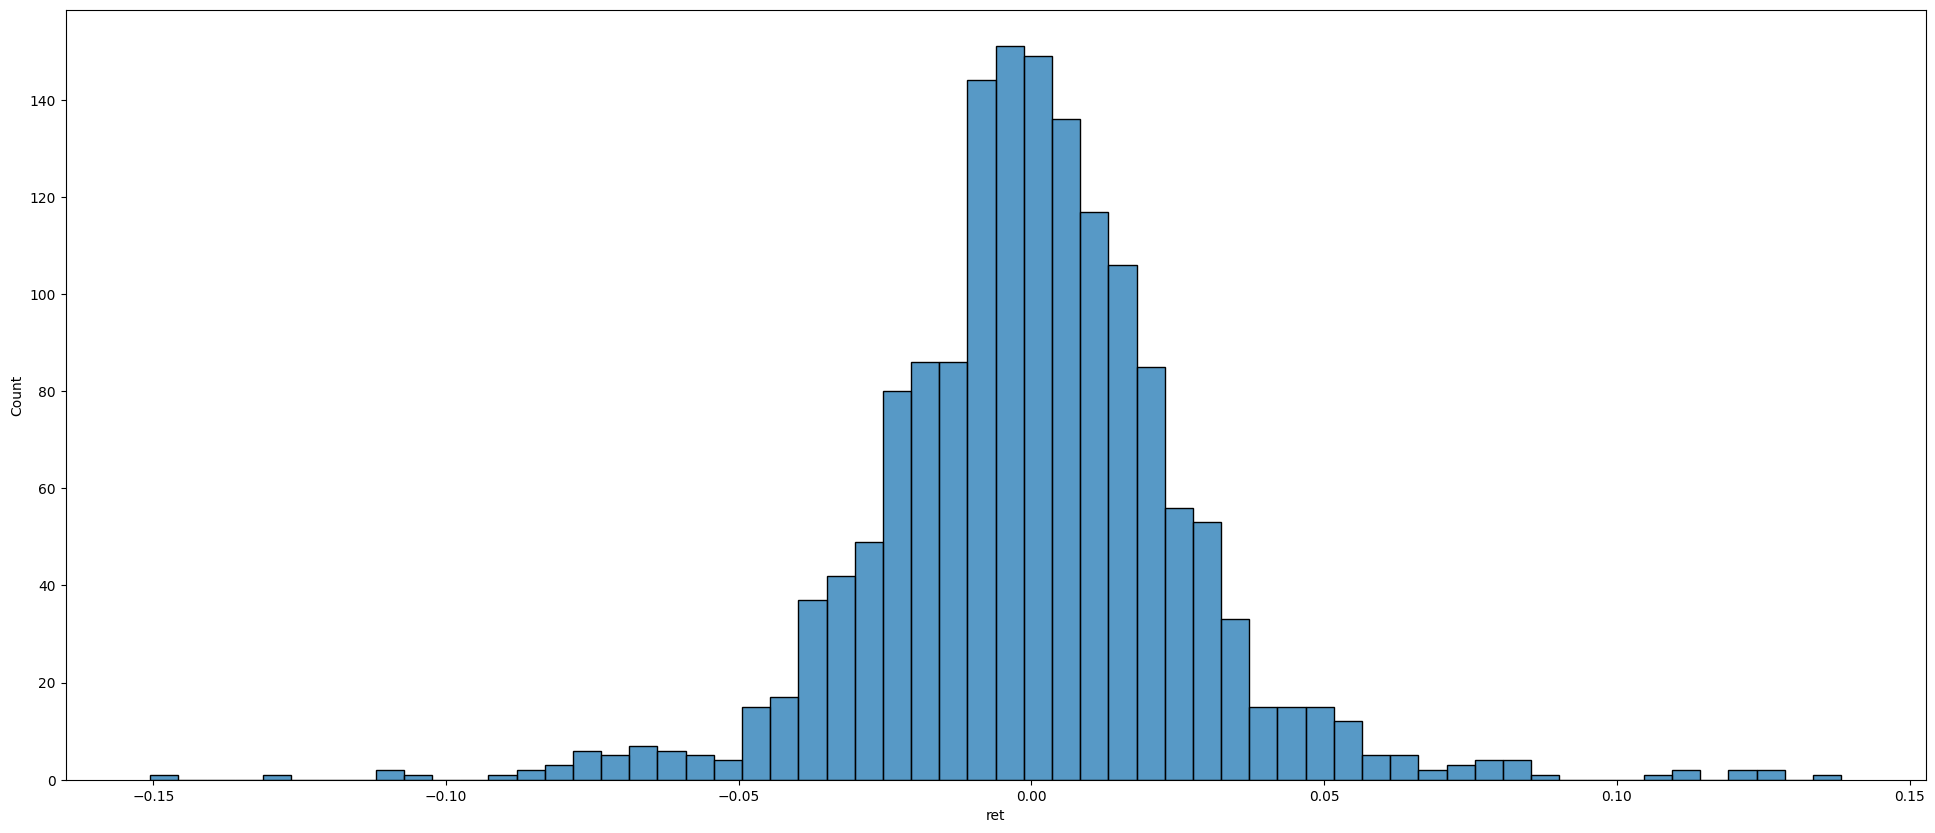

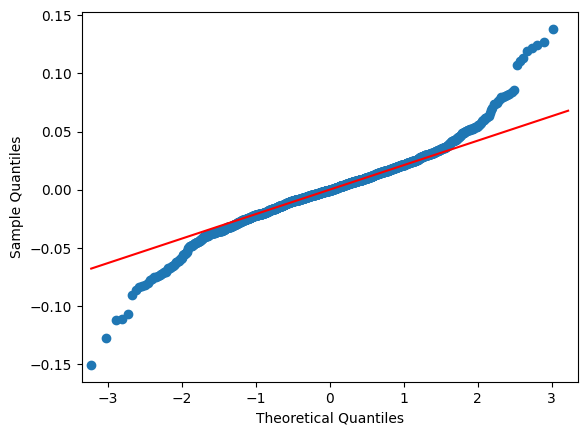

In [17]:
return_stats(data_dict['DB'], 'DB')

For Deutsche Bank,
The returns are healthily distributed on the center bell. It still has a thicker tails compared to Gaussian but aligns a bit towards Gaussian than Credit Suisse. Still a lot of negative returns in the data as seen on the bottom right corner

Return Stats for SIVB


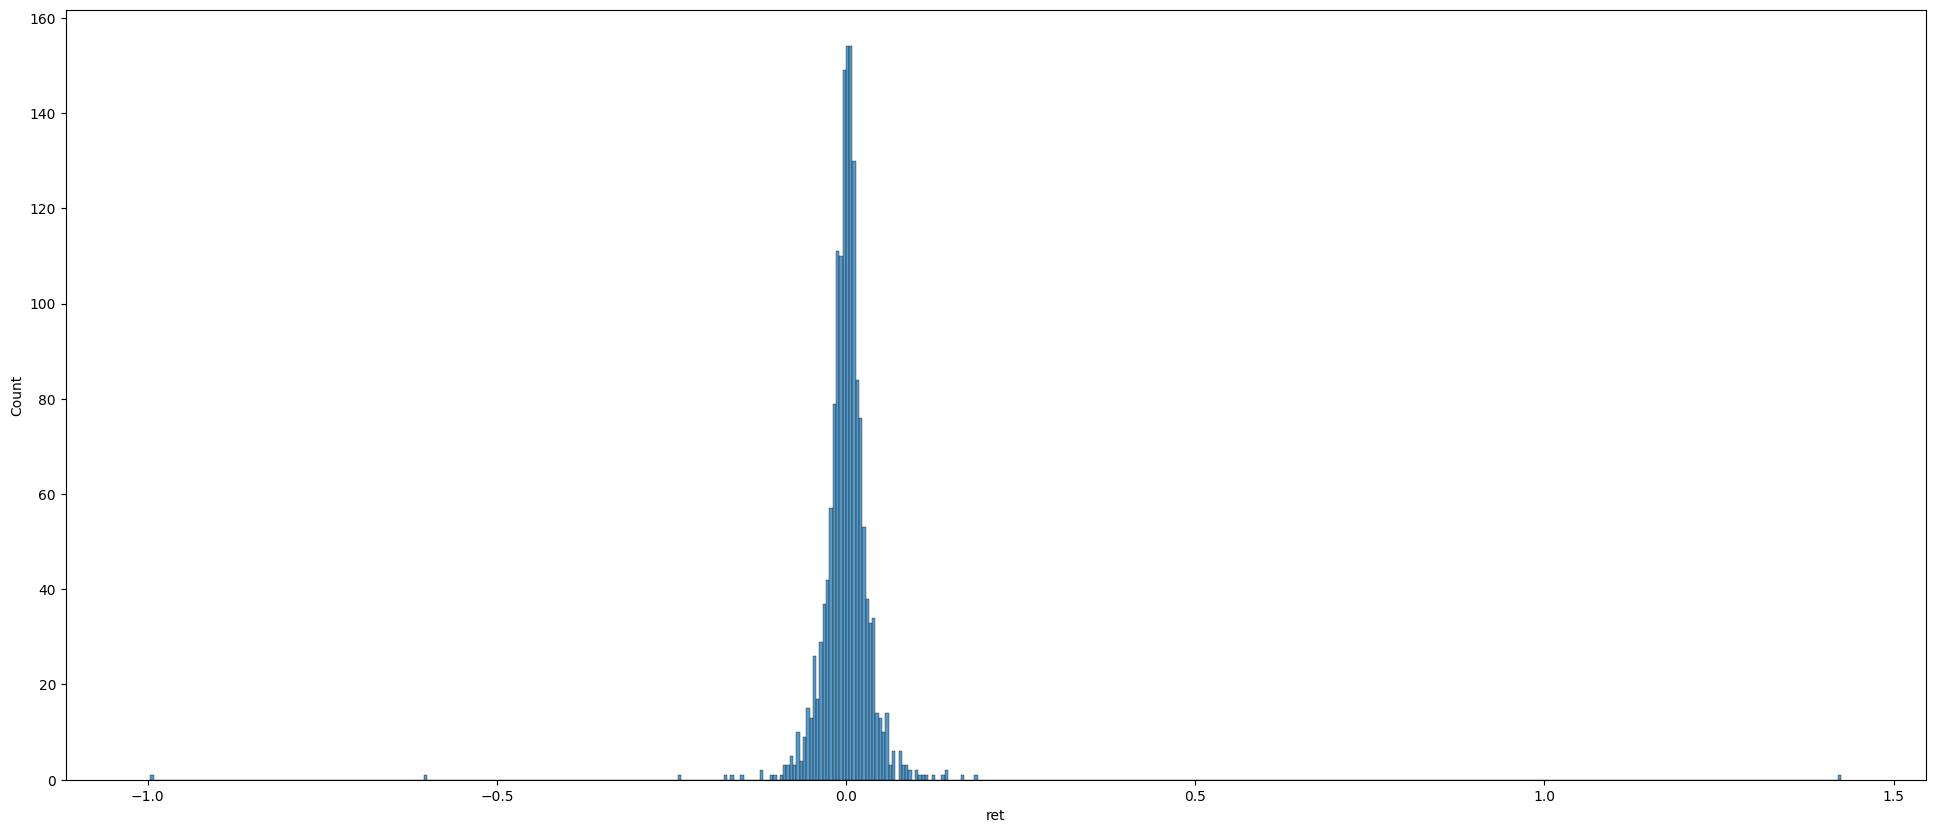

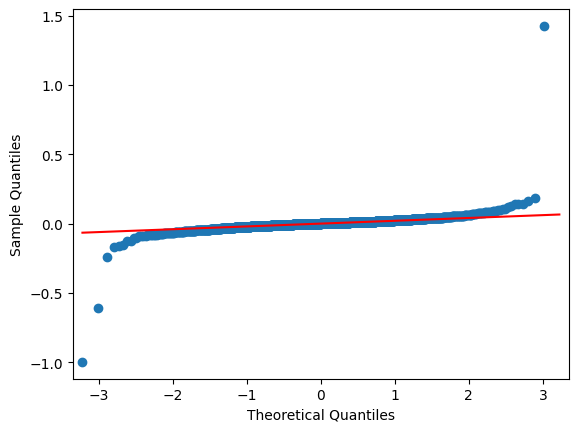

In [18]:
return_stats(data_dict['SIVB'], 'SIVB')

For SVB,
The data sort of resembles the Credit Suisse but has thicker edges and has a very peaked & narrow center. This indicates extreme values on the tails which is not a property of Gaussian

Return Stats for SBNYP


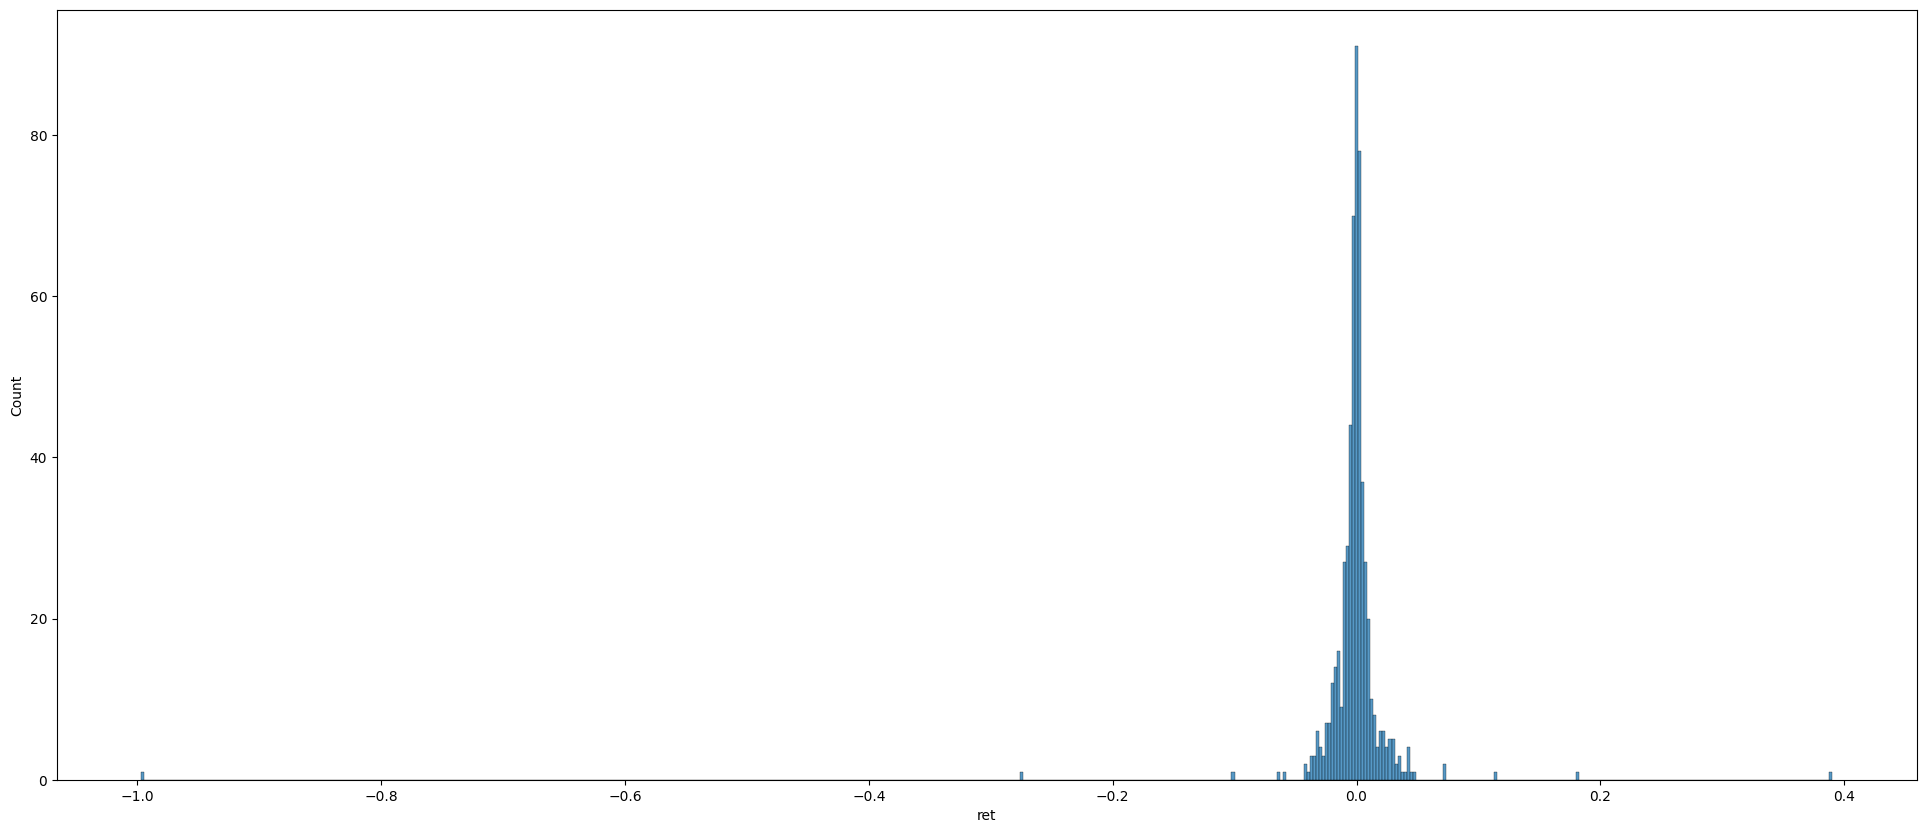

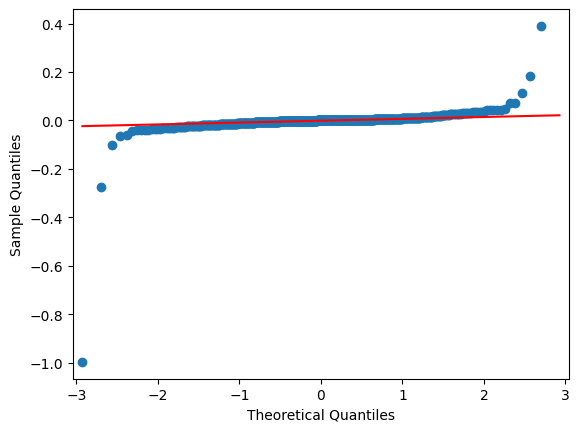

In [19]:
return_stats(data_dict['SBNYP'], 'SBNYP')

For Signature Bank
The data resembles that of SVB. Thick tails implying extreme values at either ends.

In [20]:
# Volume Analysis
def volume_analysis(df, name):
    print(f'Volume Analysis for {name}')

    print(f'Max Volume: {max(df.Volume)} on {df.loc[df.Volume==max(df.Volume)].Date.item()}')
    print(f'Min Volume: {min(df.Volume)} on {df.loc[df.Volume==min(df.Volume)].iloc[-1].Date}')
    print(f'Average Volume: {df.Volume.mean().item()}')
    print(f'Correlation of Returns & Volume Traded: {df.Close.pct_change().corr(df.Volume)}')

for name, df in data_dict.items():
    volume_analysis(df, name)
    print()
    print()

Volume Analysis for credit_suisse
Max Volume: 434104000 on 2023-03-15
Min Volume: 414100 on 2020-12-24
Average Volume: 7180016.3705583755
Correlation of Returns & Volume Traded: -0.37913177827190686


Volume Analysis for DB
Max Volume: 36856400 on 2023-03-24
Min Volume: 0 on 2019-12-27
Average Volume: 5108408.946700508
Correlation of Returns & Volume Traded: -0.10054837700007885


Volume Analysis for SBNYP
Max Volume: 10396770 on 2023-03-28
Min Volume: 0 on 2023-03-27
Average Volume: 156154.30412371134
Correlation of Returns & Volume Traded: -0.45857089626463493


Volume Analysis for SIVB
Max Volume: 84502118 on 2023-03-28
Min Volume: 0 on 2023-03-27
Average Volume: 723347.8953045686
Correlation of Returns & Volume Traded: -0.057772527506385354




#Conclusion
Signature & SIVB are no longer traded.

The above 2 banks had Maximum Volume on or after the day they collapsed.

Signature Bank has a strong negative correlation with Returns followed by Credit Suisse.